# Brain Tumour Detection

In [3]:
# Colab library to upload files to notebook
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


In [84]:
def edgeDetection(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box for each contour
    boxes = [cv2.boundingRect(c) for c in cnts]
    return cnts
    

def findTumorContour(image, debug = False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
    # #Histogram equalization
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # gray = clahe.apply(gray)
    #Gaussian blur
    gray =  cv2.GaussianBlur(gray, (5, 5), 0)
    #Thresholding
    _, thresh = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
    _, threshInv = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)

    #thresh = (thresh + threshInv) //2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    closed = cv2.erode(closed, None, iterations = 19)
    closed = cv2.dilate(closed, None, iterations = 17)
    _,mask = cv2.threshold(closed, 155, 255, cv2.THRESH_BINARY) 
    final = cv2.bitwise_and(image,image,mask = mask) 
    boxes = edgeDetection(mask)

    if debug:
        # shows gray, thresh, closed, mask, final image in subplots
        plt.figure(figsize=(10,10))
        plt.subplot(321)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.subplot(322)
        plt.imshow(gray, cmap='gray')
        plt.title('Gray Image')
        plt.subplot(323)
        plt.imshow(thresh, cmap='gray')
        plt.title('Threholding')
        plt.subplot(324)
        plt.imshow(closed, cmap='gray')
        plt.title('Closing operation')
        plt.subplot(325)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.subplot(326)
        plt.imshow(final, cmap='gray')
        plt.title('Final Result')
        plt.show()

    return boxes

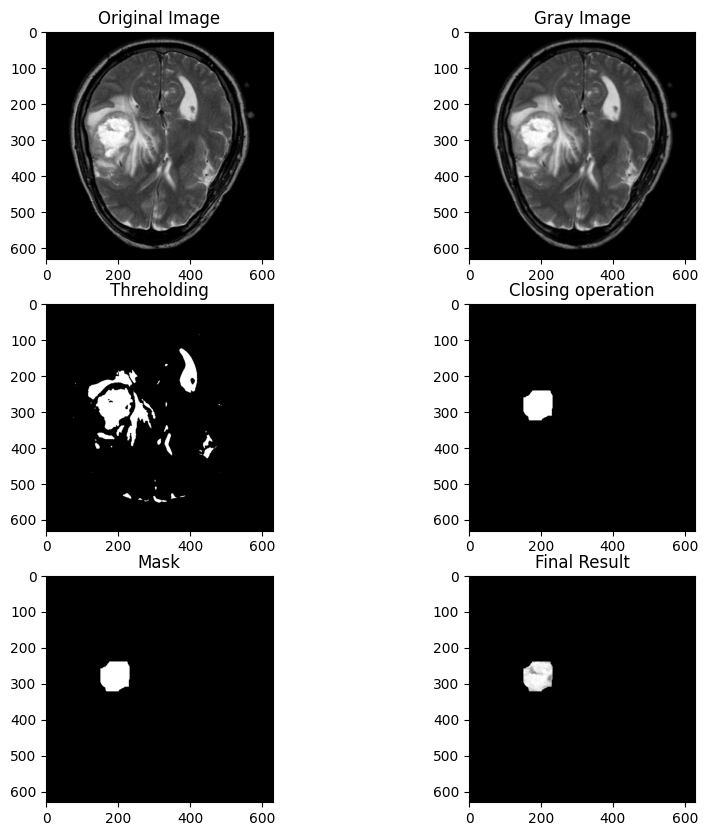

In [85]:
img_path = "dataset/train/images/y100.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
tumors = findTumorContour(img, debug=True)


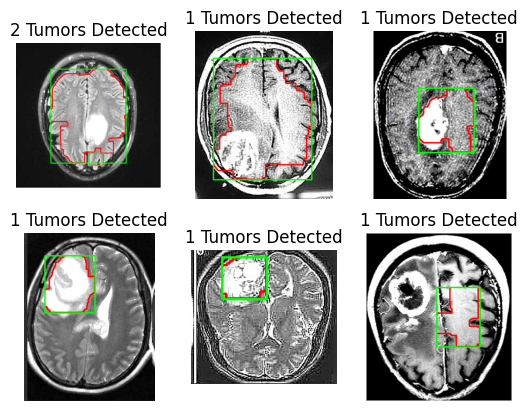

In [88]:


num_test = 6 
#Test haar cascade classifier
def test_image():
    #Create matplotlib subplot equals to num_test
    fig, axs = plt.subplots(2, num_test//2)
    axs = axs.ravel()
    for i in range(num_test):
        id = np.random.randint(1, 499)
        img_path = "dataset/train/images/y{id}.jpg".format(id=id)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        tumors = findTumorContour(img)
        cv2.drawContours(img, tumors, -1, (0, 0, 255), 2)
        boxes = [cv2.boundingRect(c) for c in tumors]
        for (x1,y1,x2,y2) in boxes:
            cv2.rectangle(img, (x1,y1), (x1+x2,y1+y2), (0,255,0), 2)
        
        title = f"{len(tumors)} Tumors Detected"
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].axis('off')
        axs[i].set_title(title)
    plt.show()
        

test_image()

In [ ]:

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=1
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def nms(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def get_boxes(self, label_dir , format = 'yolo', index = 0 ,w_img = None , h_img = None):
        if format == 'yolo':
            with open(label_dir, 'r') as f:
                boxes = f.readlines()
                boxes = [box.strip().split() for box in boxes]
                formatted_boxes = []
                for class_pred, x, y, w, h in boxes:
                    x, y, w, h = float(x), float(y), float(w), float(h)

                    if self.box_format == "midpoint":
                        x = (x - w / 2) 
                        y = (y - h / 2) 
                    if w_img is not None and w_img>= 0 and h_img is not None and  h_img >= 0:
                        x = int(x*w_img)
                        y = int(y*h_img)
                        w = int(w*w_img)
                        h = int(h*h_img)
                    formatted_boxes.append([index, int(class_pred), 1, x, y, w, h])
            return formatted_boxes
                
        else:
            return None